In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Isolation forest 를 사용한 이상치 제거

Scikit learn 에서 제공하는 Isolation forest 를 이용하여
학습 데이터의 이상치를 제거해보겠습니다.

Isolation forest는 전체 데이터에서 일부를 sample 한 뒤, 
데이터를 임의의 차원으로 분할하여 완전히 고립시키는데 필요한 횟수를 계산합니다.
이때 분할 횟수가 큰 값들이  outlier로 판단됩니다.
![대체 텍스트](https://i.imgur.com/JVK1ZPt.png)
출처: https://donghwa-kim.github.io/iforest.html


먼저 이상치를 제거하기 전 까지의 과정은 다음과 같습니다.

In [0]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

path = '/content/drive/My Drive/dnn_tutorial/'
#   set LABEL first
output_cols = ['vel']
#   set traffic column
input_cols = ['vel_t05', 'vel_t10', 'vel_t15', 'vel_t20',
               'vel_t25', 'vel_t30', 'vel_t35',  'vel_t40']

In [0]:
model = keras.Sequential()
model.add(keras.layers.Dense(30, input_shape = (len(input_cols),),activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(1, activation=None))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mape'])

In [0]:
traffic_data = pd.read_csv(path+ 'traffic_data_org.csv', index_col = 0)

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(traffic_data, test_size = 1024)

이제 train_data 에서 이상치를 제거해보겠습니다.



In [0]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100)
clf.fit(train_data)
y_outlier = clf.predict(train_data)
y_outlier = pd.DataFrame(y_outlier, index= train_data.index, columns = ['Top'])
y_outlier

,Top
8288223,-1
8288594,1
8234273,1
8232338,1
8247176,1
...,...
8247860,1
8237918,1
8225493,1
8237964,1


In [0]:
train_data = train_data.loc[y_outlier[y_outlier['Top'] == 1].index]
train_data

,vel,date,time,vel_t05,vel_t10,vel_t15,vel_t20,vel_t25,vel_t30,vel_t35,vel_t40
8288594,87.71000,20151109,110,88.350000,92.35000,87.32000,88.11000,89.09,88.13,83.72000,92.920006
8234273,93.74000,20150501,400,88.430000,92.40000,92.47000,93.44000,92.99,91.08,99.07000,96.500000
8232338,94.59000,20150422,1045,96.470000,95.92000,97.24000,98.22000,95.47,96.62,97.90000,95.510000
8247176,101.81000,20150615,115,98.840004,103.59000,103.70999,101.10000,98.37,102.61,97.71000,100.290000
8301930,98.41000,20151225,1020,94.600000,97.54000,99.38999,99.02999,98.07,99.21,103.44001,101.690000
...,...,...,...,...,...,...,...,...,...,...,...
8247860,96.51000,20150617,1015,94.660000,95.51000,96.53000,96.10000,95.98,96.38,98.72000,97.650000
8237918,96.76001,20150513,2050,95.090000,94.95000,96.01001,94.51000,93.72,93.09,91.36000,93.970000
8225493,102.13000,20150329,1430,102.840000,102.49000,101.10000,103.32000,102.55,104.12,103.10000,104.190000
8237964,91.95000,20150514,40,96.570000,98.15001,100.64000,96.81000,97.92,96.43,91.31000,98.490000


train_data 에서 상당한 데이터가 제거된 것을 확인할 수 있습니다.

이상치가 제거된 training data로 모델을 학습 시킨후 결과를 확인하겠습니다.

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
scaler.fit(train_data['vel'].values.reshape(-1,1))

def normalize_numeric(dataframe, input_col_list, output_col_list):
    return_df = dataframe.copy()
    for col in input_col_list:
        return_df.loc[:, col] = pd.DataFrame(
            scaler.transform(return_df[col].values.reshape(-1, 1)),
            columns=[col], index=return_df.index)
    for col in output_col_list:
        col_backup = 'backup_'+col
        return_df[col_backup] = return_df[col].copy()
    for col in output_col_list:
        return_df.loc[:, col] = pd.DataFrame(
            scaler.transform(return_df[col].values.reshape(-1, 1)),
            columns=[col], index=return_df.index)
    return return_df

train_data = normalize_numeric(train_data, input_cols, output_cols)
test_data = normalize_numeric(test_data, input_cols, output_cols)

X_train = train_data[input_cols].values
Y_train = train_data[output_cols].values

In [0]:
model.fit(X_train, Y_train, batch_size=1024, epochs= 10)
train_predict= model.predict(X_train)
train_predict =pd.DataFrame(scaler.inverse_transform(train_predict)
, index= train_data.index, columns=['prediction'])
percentage_error = (train_predict['prediction'] - train_data['backup_vel']).abs()/ train_data['backup_vel']*100
print(percentage_error)
print(percentage_error.mean())

Epoch 1/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0272 - mape: 10171.4609
Epoch 2/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0012 - mape: 8636.8604
Epoch 3/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0011 - mape: 8565.3955
Epoch 4/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0011 - mape: 8543.8564
Epoch 5/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0011 - mape: 8450.4189
Epoch 6/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0011 - mape: 8429.2822
Epoch 7/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0010 - mape: 8413.7158
Epoch 8/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0010 - mape: 8392.3125
Epoch 9/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0010 - mape: 8362.5234
Epoch 10/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0010 - mape: 8341.8994
8288594    3.753250
8234273 

이상치 제거 결과 training 에러가 상당히 감소한 것을 볼 수 있습니다.
test 에러를 확인하면 다음과 같습니다.

In [0]:
test1_data = pd.read_csv(path+'traffic_data_test1.csv', index_col = 0)
test1_data = normalize_numeric(test1_data, input_cols, output_cols)

X_test1 = test1_data[input_cols].values
Y_test1 = test1_data[output_cols].values

model.evaluate(X_test1, Y_test1)

32/32 [==============================] - 0s 1ms/step - loss: 0.0024 - mape: 7.5912


[0.002372202929109335, 7.5912370681762695]

9/9 [==============================] - 0s 1ms/step - loss: 0.0092 - mape: 366.6809


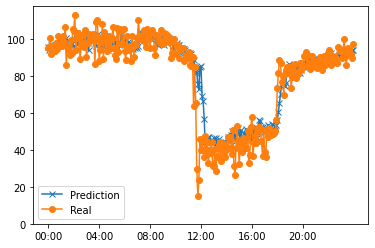

In [0]:
test2_data = pd.read_csv(path+'traffic_data_test2.csv', index_col = 0)
test2_data = normalize_numeric(test2_data, input_cols, output_cols)
test2_data['date'] = pd.to_datetime(test2_data['date'], format='%Y%m%d')
test2_data['time'] = test2_data['time'].map(
                        lambda x: pd.Timedelta(hours=x // 100, minutes=x % 100))
test2_data['datetime'] = test2_data['date'] + test2_data['time']

X_test2= test2_data[input_cols].values
Y_test2 =  test2_data[output_cols].values
model.evaluate(X_test2, Y_test2)
prediction = model.predict(X_test2)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.plot(scaler.inverse_transform(prediction),'-x',test2_data['backup_vel'], '-o')
ax.set_ylim(bottom=0)
xtick_list = [x for x in range(
        0, len(Y_test2), len(Y_test2) // 6)]
ax.set_xticks(xtick_list)
ax.set_xticklabels([test2_data['datetime'][x].strftime('%H:%M') for x in xtick_list])
ax.legend(['Prediction', 'Real'])